In [1]:
import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
import matplotlib.pyplot as plt


In [8]:
!wget "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"

--2023-04-11 06:05:02--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-04-11 06:05:02 (8.34 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [11]:
def read_txt(txt_path):
  with open(txt_path, 'r') as f:
    txt_string = f.readlines()
  return txt_string

txt_string = read_txt('names.txt')

In [15]:
names = [x[:-1] for x in txt_string]
len(names)

32033

In [77]:
# 2-gram 
entire_ngram = []
n = 5

for name in names:
  len_name = len(name)
  for i in range(len(name)-(n-1)):
    n_gram = name[i:i+n]
    entire_ngram.append(n_gram)

In [78]:
from collections import Counter

n_gram_counter = Counter(entire_ngram)

In [79]:
# how many combination exists?
len(n_gram_counter)

28796

In [80]:
n_gram_counter.most_common(10)

[('leigh', 234),
 ('ianna', 127),
 ('amari', 125),
 ('elynn', 92),
 ('abell', 90),
 ('yanna', 90),
 ('bella', 84),
 ('oluwa', 79),
 ('alynn', 78),
 ('angel', 75)]

In [ ]:
n_gram_keys = sorted(list(n_gram_counter.keys()))
n_gram_keys

In [41]:
n_gram_counter['ab']

541

In [43]:
starting_characters = list(set([x[0] for x in n_gram_keys]))

example_chr = starting_characters[0]
example_chr
corresp_ngram_words = [x for x in n_gram_keys if x[0] == example_chr]
total_chr_appearance = sum([n_gram_counter[word] for word in corresp_ngram_words])

prob_of_words = [n_gram_counter[x]/total_chr_appearance for x in corresp_ngram_words]


In [ ]:
prob_of_words

In [47]:
starting_characters = sorted(list(set([x[0] for x in n_gram_keys])))
len(starting_characters)

26

In [ ]:
# Make transition matrix
import numpy as np

transition = np.zeros([26, 26], dtype=np.int)
chrs = sorted(list(set([x[0] for x in n_gram_keys])))
chrs

In [56]:
for i, start in enumerate(chrs):
  for j, end in enumerate(chrs):
    transition[i, j] = n_gram_counter[start+end]

In [61]:
import torch

transition = torch.tensor(transition)
torch.set_printoptions(sci_mode=False)

In [ ]:
trans_prob = transition / transition.sum(dim=1).unsqueeze(1)
trans_prob

In [72]:
trans_prob[0].sum()

tensor(1.)

In [76]:
chrs[16], chrs[20], trans_prob[16, 20]

('q', 'u', tensor(0.8443))

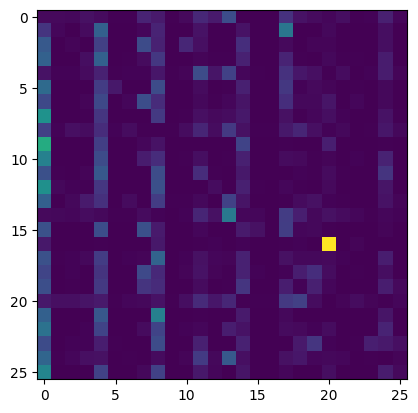

In [73]:
import matplotlib.pyplot as plt

plt.imshow(trans_prob)

## Neural Network

In [90]:
import torch
import torch.nn

class Dataset:
  def __init__(self, list_of_names):
    self.names = list_of_names
    self.chrs = sorted(list(set([chr  for name in self.names for chr in name])))
    self.tok2idx = {chr:i for i, chr in enumerate(self.chrs)}

  def __len__(self):
    return len(self.names)

  def __getitem__(self, idx):
    name = self.names[idx]
    name_in_indices = [self.tok2idx[chr] for chr in name]
    return torch.tensor(name_in_indices, dtype=torch.long)

dataset = Dataset(names)
dataset[0]

tensor([ 4, 12, 12,  0])

In [87]:
vocab_size = len(dataset.chrs)
emb_dim = 8

word_emb = nn.Embedding(vocab_size, emb_dim)

In [92]:
word_emb.weight[0]

tensor([ 1.9232,  1.1801, -0.0887, -0.5216, -0.7418,  0.1340,  0.1982,  1.7162],
       grad_fn=<SelectBackward0>)

In [93]:
name_tensor = dataset[0]
emb = word_emb(name_tensor)

In [95]:
emb.shape

torch.Size([4, 8])

In [98]:
emb[0:1]

tensor([[-0.2799, -0.2369, -0.8305, -0.0751, -0.0813, -0.6871,  0.9136, -0.5130]],
       grad_fn=<SliceBackward0>)

In [99]:
hidden_size = 12
weight_xh = nn.Linear(emb_dim, hidden_size, bias=False)

weight_xh(emb)

tensor([[ 0.2765,  0.0718, -0.2240,  0.4251, -0.5079,  0.0619,  0.1541,  0.1498,
          0.1081,  0.1318, -0.1567,  0.6033],
        [-0.3789, -0.7592,  0.6421,  0.0938,  0.9305,  0.0575, -0.2183,  0.6115,
          0.2539, -0.6574,  1.3094, -0.2639],
        [-0.3789, -0.7592,  0.6421,  0.0938,  0.9305,  0.0575, -0.2183,  0.6115,
          0.2539, -0.6574,  1.3094, -0.2639],
        [-0.8022,  0.0042, -0.6203,  0.0713, -0.3739, -0.1618,  0.5518, -0.1413,
         -0.8806, -1.0042,  0.1083,  0.2116]], grad_fn=<MmBackward0>)

In [101]:
weight_hh = nn.Linear(hidden_size, hidden_size)

initial_hidden = torch.zeros(hidden_size)

$h_1 = \sigma(W_{hh}h_{0} + W_{xh}x_{1})$


In [104]:
next_hidden = (weight_hh(initial_hidden) + weight_xh(emb[0:1])).tanh()
next_hidden

tensor([[-0.0100,  0.3083,  0.0411,  0.3529, -0.4464, -0.2156,  0.1012,  0.0840,
          0.0386,  0.0354, -0.3462,  0.5948]], grad_fn=<TanhBackward0>)

In [110]:
timestep = 0
hidden = torch.zeros(hidden_size)
total_hidden = []

for t in range(len(name_tensor)):
  emb_t = word_emb(name_tensor[t])
  hidden = (weight_hh(hidden) + weight_xh(emb_t)).tanh()
  total_hidden.append(hidden)
total_hidden

[tensor([-0.0100,  0.3083,  0.0411,  0.3529, -0.4464, -0.2156,  0.1012,  0.0840,
          0.0386,  0.0354, -0.3462,  0.5948], grad_fn=<TanhBackward0>),
 tensor([-0.5425, -0.4924,  0.7898, -0.0250,  0.8380, -0.2019, -0.0767,  0.5737,
          0.2884, -0.7382,  0.6682, -0.2965], grad_fn=<TanhBackward0>),
 tensor([-0.4872, -0.8018,  0.3790,  0.2149,  0.7639, -0.6407, -0.6718,  0.5409,
          0.2854, -0.3986,  0.9189,  0.4143], grad_fn=<TanhBackward0>),
 tensor([-0.8312, -0.5261, -0.6565,  0.2503, -0.6020, -0.7073,  0.2114, -0.5513,
         -0.5902, -0.7046, -0.0567,  0.7878], grad_fn=<TanhBackward0>)]

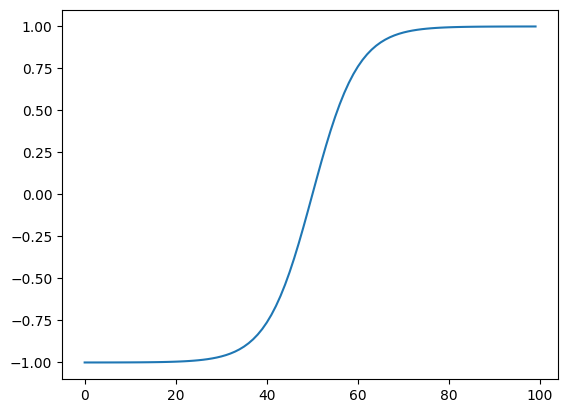

In [107]:
import matplotlib.pyplot as plt
plt.plot(((torch.arange(100) - 50)/10).tanh())